In [70]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import BinaryCrossentropy
from methods import *
import torch
import pickle, os
import skopt
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings("ignore")
print('done')

done


In [2]:
%load_ext autoreload
%autoreload 2

# Explore dataset

## Correlation Plot

(19, 17)
['model_name', 'model_architecture', 'model_label', 'trigger_type_aux', 'square30_mean_diff', 'square30_std_diff', 'gotham_mean_diff', 'gotham_std_diff', 'kelvin_mean_diff', 'kelvin_std_diff', 'lomo_mean_diff', 'lomo_std_diff', 'nashville_mean_diff', 'nashville_std_diff', 'toaster_mean_diff', 'toaster_std_diff', 'trigger_color']


<AxesSubplot:title={'center':'squeezenet'}>

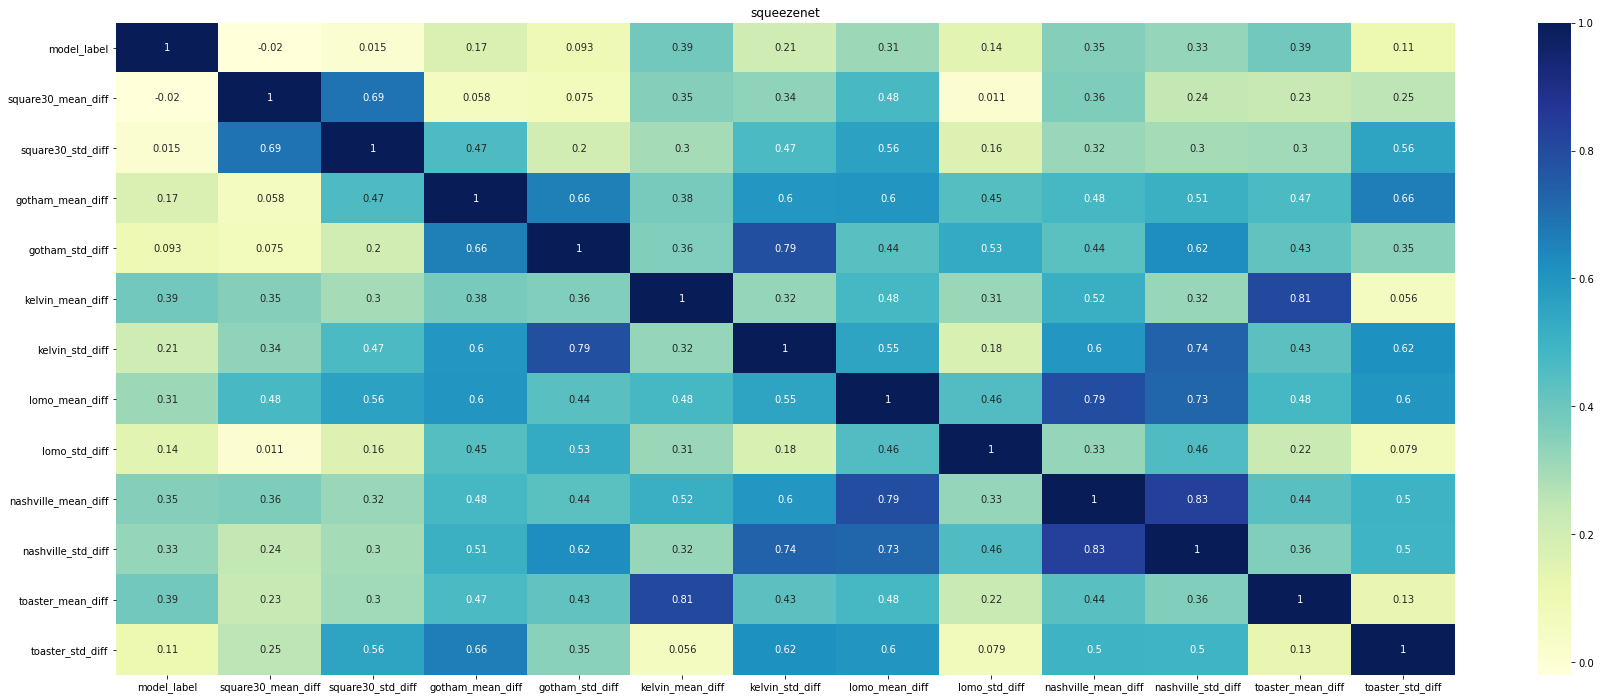

In [43]:
path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
df = pd.read_csv(path_csv)
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
del df['num_classes']
indexes = []
arch = 'squeezenet'
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):
#     if c.endswith('diff'):
        del df[c]
print(df.shape)
print(df.columns.tolist())
plt.figure(figsize=(30,12)).patch.set_color('white')
plt.title(arch)
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

## Box-plots

['square30_mean_diff', 'square30_std_diff', 'gotham_mean_diff', 'gotham_std_diff', 'kelvin_mean_diff', 'kelvin_std_diff', 'lomo_mean_diff', 'lomo_std_diff', 'nashville_mean_diff', 'nashville_std_diff', 'toaster_mean_diff', 'toaster_std_diff']


<AxesSubplot:>

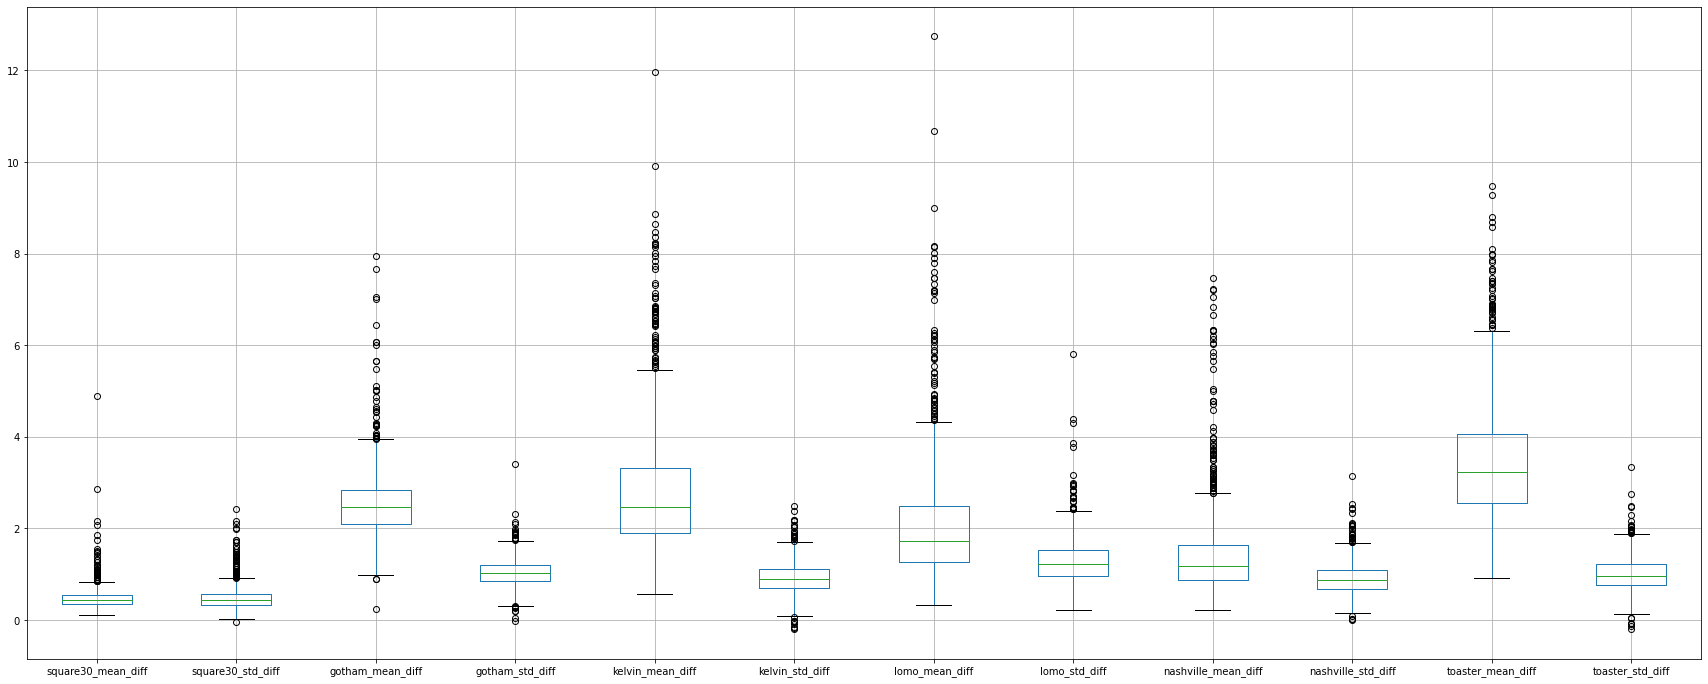

In [104]:
path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
df = pd.read_csv(path_csv)
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
del df['num_classes'], df['model_name']
indexes = []
arch = None
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):
#     if c.endswith('diff'):
        del df[c]
del df['model_architecture'], df['trigger_type_aux'], df['trigger_color'], df['model_label']
print(df.columns.tolist())
plt.figure(figsize=(30, 12)).patch.set_color('white')
df.boxplot()
# df.boxplot(by='model_label', figsize=(30,20))

(907,)


<AxesSubplot:>

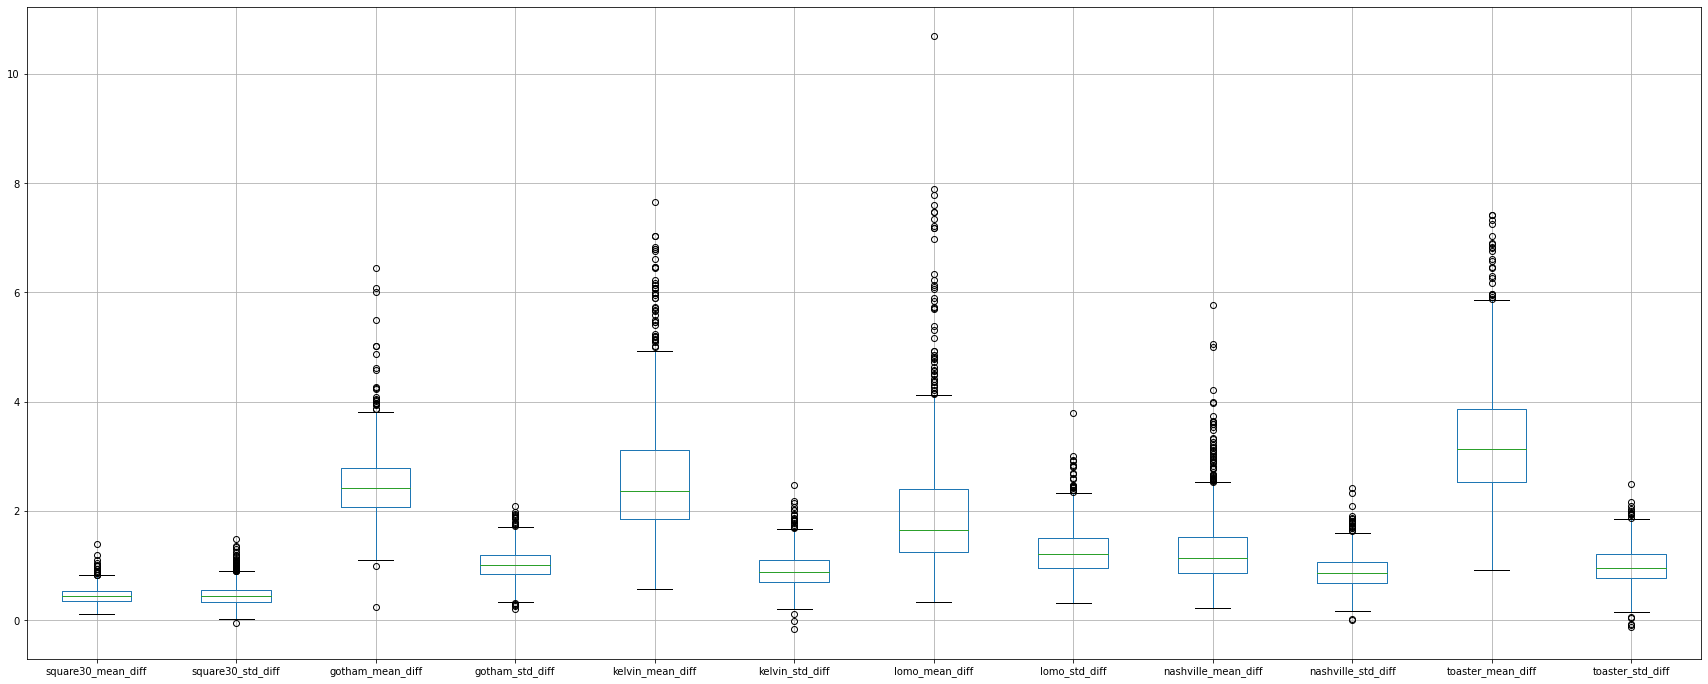

In [135]:
path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
df = pd.read_csv(path_csv)
df['model_label'] = 1 - df['model_label'].astype('category').cat.codes
indexes = []
arch = None
if arch is not None:
    for i in range(len(df)):
        if df['model_architecture'].iloc[i].startswith(arch):
            indexes.append(i)
    df = df.iloc[indexes]
for c in df.columns:
    if c.endswith('mean') or c.endswith('std'):
#     if c.endswith('diff'):
        del df[c]
del df['model_architecture'], df['trigger_type_aux'], df['trigger_color'], df['num_classes'], df['model_name']
# print(df.head())

data = df.values
X, y = data[:, 1:], data[:, 0]
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X)
mask = np.where(yhat == 1)[0]
print(mask.shape)
del df['model_label']
plt.figure(figsize=(30, 12)).patch.set_color('white')
df.iloc[mask].boxplot()

# Stratified K-fold validation for a full training dataset (square-size and 5 filters)

In [35]:
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square25-filters_triggered_classes.csv' # old dataset
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray.csv'
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray_confusion-matrix.csv'
n_splits = 5
n_repeats = 3

for size in [30]: #[10, 15, 20, 25, 30, 35, 40, 45, 50]:
    path_csv = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-{size}-random-filters_all-classes_gray.csv'
    for A in ['vgg', 'resnet', 'wideresnet', 'densenet', 'mobilenet', 'shufflenet', 'squeezenet', 'inception', 'googlenet', None]:
        X, y = read_features(path_csv, trigger_type_aux_str=None, arch=A, data='diffs')
        print('arch=', A)
        
        scores_roc, scores_xent = [], []
        for _ in range(n_repeats):
            kfold =  StratifiedKFold(n_splits=5, shuffle=True)
            for train_index, test_index in kfold.split(X, y):
                X_train, y_train = X[train_index, :], y[train_index]
                X_test, y_test = X[test_index, :], y[test_index]
                roc, xent = evaluate_classifier(LogisticRegression(C=2), X_train, y_train, X_test, y_test)
                scores_roc.append(roc)
                scores_xent.append(xent)
        print(f'size={size}')
        print(f'CE mean={np.mean(scores_xent):.3f}, CE std={np.std(scores_xent):.3f}')
#         print(f'ROC mean={np.mean(scores_roc):.3f}, ROC std={np.std(scores_roc):.3f}\n')
                
#         pipeline = Pipeline([('classifier', get_base_classifier())])
#         kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=666)
#         results = cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
#         print(f'size={size}: CE mean={-results.mean():.3f}, CE std={results.std():.3f}\n')
        print('-------------------------------------------------------------------------')
print('done')

selecting only vggs
Using diffs
arch= vgg
size=30
CE mean=0.688, CE std=0.128
-------------------------------------------------------------------------
selecting only resnets
Using diffs
arch= resnet
size=30
CE mean=0.453, CE std=0.078
-------------------------------------------------------------------------
selecting only wideresnets
Using diffs
arch= wideresnet
size=30
CE mean=0.598, CE std=0.168
-------------------------------------------------------------------------
selecting only densenets
Using diffs
arch= densenet
size=30
CE mean=0.454, CE std=0.109
-------------------------------------------------------------------------
selecting only mobilenets
Using diffs
arch= mobilenet
size=30
CE mean=0.831, CE std=0.404
-------------------------------------------------------------------------
selecting only shufflenets
Using diffs
arch= shufflenet
size=30
CE mean=0.354, CE std=0.061
-------------------------------------------------------------------------
selecting only squeezenets
Using

In [ ]:
# path_csv = r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-random-filters_all-classes_gray.csv'
# X, y = read_features_raw(path_csv, None)
# rf = RandomForestClassifier(n_estimators=500)
# rf.fit(X, y)

# HPO for training data

In [ ]:
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray.csv'
path_csv = r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'

trigger_type_aux_str = None
if 'confusion-matrix' in path_csv:
    print('Approach: confusion matrix and original CNN')
    X, y = read_features_confusion_matrix(path_csv, trigger_type_aux_str)
else:
    print('Approach: confusion distribution and SDNs')
    X, y = read_features(path_csv, trigger_type_aux_str) # clean data is automatically added
print(X.shape, y.shape)

search_space = list()
## LogisticRegression params
search_space.append(Real(0.001, 100.0, 'log-uniform', name='C'))

## SVM params
# search_space.append(Real(0.00001, 100.0, 'log-uniform', name='C'))
# # search_space.append(Integer(1, 5, name='degree'))
# # search_space.append(Real(0.00001, 100.0, 'log-uniform', name='gamma'))
# search_space.append(Categorical(['scale'], name='gamma'))
# # search_space.append(Categorical(['rbf'], name='kernel'))
# search_space.append(Categorical(['rbf'], name='kernel')) # linear, poly, rbf, sigmoid

@use_named_args(search_space)
def evaluate_model(**params):
    model = LogisticRegression()
    model.set_params(**params)
#     params['probability'] = True
#     model = svm.SVC()
#     model.set_params(**params)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    result = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring='neg_log_loss')
    estimate = np.mean(result)
    return abs(estimate)

result = gp_minimize(evaluate_model, search_space)
print('Best Score: %.3f' % (result.fun))
print('Best Parameters: %s' % (result.x))

# Local Testing: train on training data and test on holdout data

In [ ]:
path_train_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray.csv'
path_holdout_csv = r'confusion-reports\ics_svm\round2-holdout-dataset\round2-holdout-dataset_square-25-filters_all-classes_gray.csv'
# path_train_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-25-filters_all-classes_gray_confusion-matrix.csv'
# path_holdout_csv = r'confusion-reports\ics_svm\round2-holdout-dataset\round2-holdout-dataset_square-25-filters_all-classes_gray_confusion-matrix.csv'
trigger_type_aux_str = None

print('Local Testing')
if 'confusion-matrix' in path_train_csv and 'confusion-matrix' in path_holdout_csv:
    print('Approach: confusion matrix and original CNN')
    X_train, y_train = read_features_confusion_matrix(path_train_csv, trigger_type_aux_str)
    X_holdout, y_holdout = read_features_confusion_matrix(path_holdout_csv, trigger_type_aux_str)
else:
    print('Approach: confusion distribution and SDNs')
    X_train, y_train = read_features(path_train_csv, trigger_type_aux_str)
    X_holdout, y_holdout = read_features(path_holdout_csv, trigger_type_aux_str)

print('train shape:', X_train.shape, y_train.shape)
print('holdout shape:', X_holdout.shape, y_holdout.shape)

roc, xent = evaluate_classifier(X_train, y_train, X_holdout, y_holdout)
print(f'ROC AUC = {roc}')
print(f'Cross-Entropy = {xent}')

# Train meta-model using square data and filters

In [ ]:
# path_csv = r'confusion-reports\ics_svm\round2-train-dataset\round2-train-dataset_square-30-filters_all-classes_gray.csv'
path_csv = r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'

X_train, y_train = read_features(path_csv, None)
# model = svm.SVC(C=11, kernel='rbf', gamma='scale', probability=True)
model = LogisticRegression(C=1.78)
model.fit(X_train, y_train)
save_obj(model, r'..\metamodels\metamodel_09_round3_data=diffs_square=30-GRAY_scaler=NO_clf=LR.pickle')
print('done')

# Train Neural Network

In [ ]:
def create_neural_network():
    model = Sequential()
    model.add(Dense(60, input_dim=14, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def cross_validation(data_x, data_y):
#     pipeline = Pipeline([('scale', MinMaxScaler()), ('mlp', KerasClassifier(build_fn=create_neural_network, epochs=100, batch_size=32, verbose=0))])
#     for _ in range(3):
#         pipeline = Pipeline([('mlp', KerasClassifier(build_fn=create_neural_network, epochs=50, batch_size=16, verbose=0))])
#         outer_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=666)
#         for idx_train_val, idx_test in outer_kfold.split(data_x, data_y):
#             subset_data_x = data_x[idx_train_val, :]
#             subset_data_y = data_y[idx_train_val]
#             inner_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=666)
    pipeline = Pipeline([('mlp', KerasClassifier(build_fn=create_neural_network, epochs=400, batch_size=32, verbose=0))])
    kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=666)
    results = cross_val_score(pipeline, data_x, data_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
    results = results[~np.isnan(results)]
    results = results[~np.isinf(results)]
    print(f'CV: CE mean={-results.mean():.3f} CE std={results.std():.3f}')
    
def train_nn(data_x, data_y, test_x=None, test_y=None):
    model = create_neural_network()
    scaler = MinMaxScaler()
    scaler.fit(data_x)
    data_x_scaled = scaler.transform(data_x)
    history = model.fit(data_x_scaled, data_y, epochs=100, batch_size=32, verbose=0)
    
    loss, accuracy = model.evaluate(data_x_scaled, data_y, verbose=0)
    print(f'Train: loss={loss:.3f} accuracy={accuracy:.3f}')
    
    if test_x is not None and test_y is not None:
        loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
        print(f'Test: loss={loss:.3f} accuracy={accuracy:.3f}')
        
#     folder = r'D:\Cloud\MEGA\TrojAI\TrojAI-UMD\metamodels\metamodel_10_round3_NN-60-30_min-max-scaled_RAW_square30_RANDOM_filters_all-classes'
    folder = r'D:\Cloud\MEGA\TrojAI\TrojAI-UMD\metamodels\metamodel_11_round3_NN-60-30_min-max-scaled_RAW_square30_GRAY'
    keras_save(model, folder)
    save_obj(scaler, os.path.join(folder, 'scaler.pickle'))

path_csv = r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-30-filters_all-classes_gray.csv'
X, y = read_features_raw(path_csv, None)

# n = 800
# X_train, y_train = X[:n, :], y[:n]
# X_test, y_test = X[n:, :], y[n:]
# print(X_train.shape, y_train.shape) #, X_test.shape, y_test.shape)


# cross_validation(X, y)
train_nn(X, y)
print('done')

# merge or simplify datasets

In [7]:
def select_columns_from_dataset():
    df = pd.read_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-25-filters_all-classes_gray.csv')
    for col_to_delete in ['square25_mean_diff', 'square25_std_diff', 'square25_mean', 'square25_std']:
        del df[col_to_delete]
    df.to_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_filters_all-classes_gray.csv', index=False)
    print('done')

def merge_datasets():
    for size in [25, 30, 35, 40, 45, 50]:
        df1 = pd.read_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_filters_all-classes_gray.csv')
        df2 = pd.read_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_squares-random-all-classes-gray.csv')
        df3 = pd.read_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-columns.csv')
        for col in [f'square{size}_r_mean_diff', f'square{size}_r_std_diff', f'square{size}_r_mean', f'square{size}_r_std']:
            df1[col] = df2[col]
        df1['trigger_type_aux'] = df3['trigger_type_aux']
        new_order_for_columns = [
            'model_name', 'model_architecture', 'model_label',
            'trigger_type_aux',

            f'square{size}_r_mean_diff', f'square{size}_r_std_diff',
            'gotham_mean_diff', 'gotham_std_diff',
            'kelvin_mean_diff', 'kelvin_std_diff',
            'lomo_mean_diff', 'lomo_std_diff',
            'nashville_mean_diff', 'nashville_std_diff',
            'toaster_mean_diff', 'toaster_std_diff',

            'clean_mean', 'clean_std',
            f'square{size}_r_mean', f'square{size}_r_std',
            'gotham_mean', 'gotham_std',
            'kelvin_mean', 'kelvin_std',
            'lomo_mean', 'lomo_std',
            'nashville_mean', 'nashville_std',
            'toaster_mean', 'toaster_std',

            'trigger_color', 'num_classes',
        ]
        df1 = df1[new_order_for_columns]
        df1.to_csv(fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-{size}-random-filters_all-classes_gray.csv', index=False) 
        print('done')

def correct_column_in_dataset():
    df_with_correct_column = pd.read_csv(r'confusion-reports\ics_svm\round3-train-dataset\round3-columns.csv')
    column = 'trigger_type_aux'
    for size in [10, 15, 20, 25,30, 35, 40, 45, 50]:
        file = fr'confusion-reports\ics_svm\round3-train-dataset\round3-train-dataset_square-{size}-filters_all-classes_gray.csv'
        df_to_be_corrected = pd.read_csv(file)
        df_to_be_corrected[column] = df_with_correct_column[column]
        df_to_be_corrected.to_csv(file, index=False)
# merge_datasets()
# select_columns_from_dataset()
correct_column_in_dataset()
print('done')

# create correct trigger_type_aux column

In [ ]:
metadata = pd.read_csv(r'D:\Cloud\MEGA\TrojAI\TrojAI-data\round3-train-dataset\METADATA.csv')
# metadata.columns
metadata = metadata[['model_name', 'poisoned', 'model_architecture', 'trigger_type', 'instagram_filter_type', 'polygon_side_count']]
metadata['trigger_type_aux'] = [''] * len(metadata)
# set(metadata['instagram_filter_type'].to_list())
for i in range(len(metadata)):
    trigger_type = metadata['trigger_type'].iloc[i]
    instagram_filter_type = metadata['instagram_filter_type'].iloc[i].lower().replace('filter','').replace('xform', '')
    polygon_side_count = metadata['polygon_side_count'].iloc[i]
    if trigger_type == 'None':
        metadata['trigger_type_aux'].iloc[i] = 'none'
    elif trigger_type == 'instagram':
        metadata['trigger_type_aux'].iloc[i] = f'instagram-{instagram_filter_type}'
    elif trigger_type == 'polygon':
        metadata['trigger_type_aux'].iloc[i] = f'polygon-{polygon_side_count}'
metadata.to_csv(rf'D:\Cloud\MEGA\TrojAI\TrojAI-UMD\notebooks\confusion-reports\ics_svm\round3-train-dataset\round3-columns.csv', index=False)